# PPCA in PyStan

In this notebook, we try to perform a PPCA in Pystan.

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

Here, the model is defined in Stan.

In [2]:
latent = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    // for (d in 1:D)    
    //    W[d] ~ normal(0.0,sigma);
    // sigma~lognormal(0.0, 1.0) ;
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_pystan = pystan.StanModel(model_code=latent)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_41eda57cd2918bb7843d5dfc6a1aa741 NOW.


We specify our parameters and generate some data.

In [26]:
N=10000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z),sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

And then we can optimize our parameters and latent dataset.

In [27]:
op = ppca_pystan.optimizing(data=ppca_dat)

z_sim = op['z']
sigma_sim = op['sigma']
W_sim = op['W']
x_sim = np.random.normal(np.matmul(W_sim,z_sim),sigma_sim)

Let's compare our models with the real values and the values as found by Tipping & Bishops PPCA method.

In [28]:
ppca = PPCA()
ppca.fit(x.T, mu = np.zeros(D)[np.newaxis].T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x)[0]
x_ppca = np.matmul(W,z)
# ppca_em = PPCA()
# ppca_em.fit(x, form='em', em_calc_loglikelihood=False)
# _, sigma_ppca_em, W_ppca_em = ppca.parameters()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [29]:
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)    # Since closed form- and EM PPCA have the same solutions, I left the EM solution out
print('simulated variance: ', sigma_sim**2)  # According to the docs (https://mc-stan.org/docs/2_20/functions-reference/normal-distribution.html),
                                             # the scale refers to the std. dev., but in their formulae they use sigma as the variance.
print()
print('real z: ', z)
print('PPCA z: ', z_ppca)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W: ', W_sim)
print()

real variance:  20.836443353550013
PPCA variance:  20.934021119545285
simulated variance:  6.977746251929897

real z:  [[-1.44200596 -1.63061049  1.29147959 ...  0.02721764  0.0585967
  -1.79178494]
 [-0.87424867 -0.91719074 -0.49039247 ...  0.95162808 -1.99361049
  -0.12649503]]
PPCA z:  [[ 0.12551425 -1.71182413  1.64469791 ... -0.12993164  0.62121941
  -2.49600871]
 [ 1.90897166  1.24495882  2.26128928 ...  1.05964337 -2.7053072
   0.52030119]]
simulated z:  [[ 0.00379567  0.02488727 -0.02501792 ... -0.00479292 -0.00399828
   0.04100988]
 [-0.00747799  0.01212537 -0.01794055 ...  0.00216656 -0.00233136
   0.01800682]]

real W:  [[-1.96988684  2.96017255]
 [-0.07778601  2.51745399]
 [-4.62779585  0.94468322]]
PPCA W:  [[-3.17655393 -2.3759939 ]
 [-3.75653426  0.82211225]
 [-2.5987161   1.71591654]]
simulated W:  [[100.09911483 271.4969869 ]
 [-60.14386793 303.00537363]
 [393.83912714 -83.59962396]]



Since $W$ can be rotated, we will compare the shapes of $W$ with the estimate of $W$ and the PPCA solution.

In [30]:
print('Original W and Simulated W:')
rotation_check(W,W_sim, verbose=True)
rotation_check(W,W_sim, verbose=True, method='angles')
print()
print('Original W and PPCA W:')
rotation_check(W,W_ppca, verbose=True)
rotation_check(W,W_ppca, verbose=True, method='angles')
print()
print('PPCA W and simulated W:')
rotation_check(W_ppca,W_sim, verbose=True)
rotation_check(W_ppca,W_sim, verbose=True, method='angles')

Original W and Simulated W:
These might not be rotations. det(R)= -9809.703962105334 R.T*R=
 [[ 8904.98171016 -7097.06567532]
 [-7097.06567532 16462.54173174]]
These matrices differ in magnitude on row 2 as they are of length 6.344 and 83730.447 (0.000x).
These matrices differ in magnitude on row 2 as they are of length 12.643 and 95429.541 (0.000x).
These matrices differ in magnitude on row 2 as they are of length 22.309 and 162098.155 (0.000x).
These matrices are approximately equal on the angle between axis 0 and 1 as they are 0.556 and 0.549.
These matrices differ at least on the angle between axis 0 and 2 as they are 0.782 and 1.427.
These matrices differ at least on the angle between axis 1 and 2 as they are 1.339 and 1.976.

Original W and PPCA W:
These might not be rotations. det(R)= -0.4483742699191132 R.T*R=
 [[1.42753688 0.3936638 ]
 [0.3936638  0.24938807]]
These matrices differ in magnitude on row 2 as they are of length 6.344 and 9.698 (0.654x).
These matrices differ in m

False

It looks like the PPCA solutions are identical (as expected), but not entirely equal to the real solution. The PyStan solution differs even more from the original $W$. One consistent difference is that the values of the simulated $W$ are significantly larger.

The result is plotted below. Similarly to what happened in TensorFlow Probability, the observed data $x$ is predicted accurately, but the latent data $z$ has smaller values, in accordance with the higher values of the solution for $W$. The value for $\sigma$ is also off.

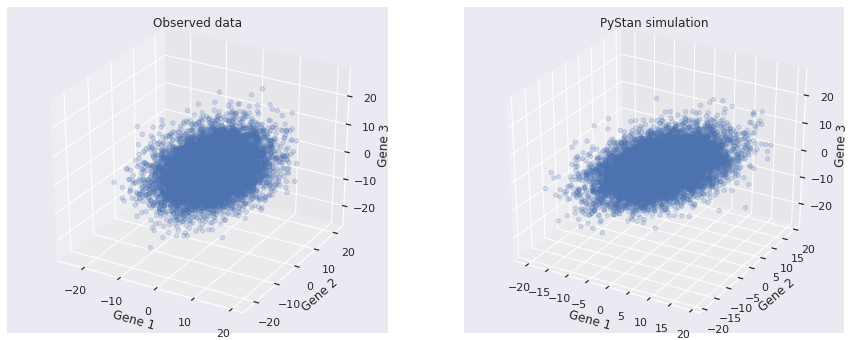

In [31]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x_sim[0,:],x_sim[1,:],x_sim[2,:], alpha=0.2)
ax.set_title('PyStan simulation')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

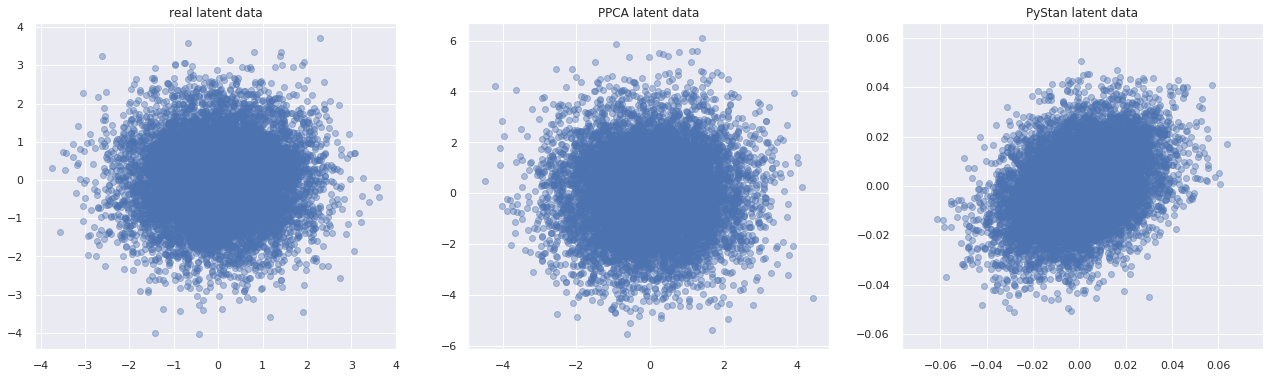

In [32]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_ppca[0,:], z_ppca[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z_sim[0,:], z_sim[1,:], alpha=0.4)
ax.set_title('PyStan latent data')
plt.show()

We can also try to add a $\mu$ to the $x$ values:

In [10]:
latent_mu = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
    vector[D] x[N];//  observations
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    vector[D] mu;   //  added means
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    //for (d in 1:D){
    //    W[d] ~ normal(0.0,sigma);
    //    mu[d]~normal(0.0, 5.0) ;
    //    }
    //sigma~lognormal(0.0, 1.0) ;
    
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n)+mu, sigma);
        
}
"""
ppca_pystan_mu = pystan.StanModel(model_code=latent_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_105ba88cde53b0932d23ebb13d8d6597 NOW.


In [33]:
N=10000
M=2
D=3
z = np.random.normal(0,1, size=(M,N))
sigma = np.random.uniform(0,5)
mu = np.random.normal(0,15,size=(D,1))
W = np.random.normal(0,sigma,size=(D,M))
x = np.random.normal(np.matmul(W,z)+mu,sigma)
    
ppca_dat = {'N': N, 'D':D, 'M':M, 'x':x.T}

In [34]:
op = ppca_pystan_mu.optimizing(data=ppca_dat)

z_sim = op['z']
sigma_sim = op['sigma']
W_sim = op['W']
mu_sim = op['mu']
x_sim = np.random.normal(np.matmul(W_sim,z_sim)+mu_sim[np.newaxis].T,sigma_sim)

In [35]:
ppca = PPCA()
ppca.fit(x.T)
mu_ppca, sigma_ppca, W_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(W_ppca, x-mu_ppca)[0]
x_ppca = np.matmul(W,z)
# ppca_em = PPCA()
# ppca_em.fit(x, form='em', em_calc_loglikelihood=False)
# mu_ppca_em, sigma_ppca_em, W_ppca_em = ppca.parameters()

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


In [36]:
print('real mu: ', mu)
print('PPCA mu: ', mu_ppca)
# print('PPCA mu (em): ', mu_ppca_em)
print('simulated mu: ', mu_sim)
print()
print('real variance: ', sigma**2)
print('PPCA variance: ', sigma_ppca)
# print('PPCA variance (em): ', sigma_ppca_em)
print('simulated variance: ', sigma_sim*2)
print()
print('real z: ', z)
print('PPCA z: ', z_ppca)
print('simulated z: ', z_sim)
print()
print('real W: ', W)
print('PPCA W: ', W_ppca)
# print('PPCA W (em): ', W_ppca_em)
print('simulated W: ', W_sim)
print()

real mu:  [[ 28.10113179]
 [ -2.56614037]
 [-15.51497059]]
PPCA mu:  [[ 28.10046751]
 [ -2.56678943]
 [-15.51484377]]
simulated mu:  [ 28.09532923  -2.56808974 -15.52213857]

real variance:  0.0063958701314262
PPCA variance:  0.006310433223037571
simulated variance:  0.09172855336026936

real z:  [[-0.21898646  0.01216752 -1.16065035 ...  0.02239578  1.44748884
   1.17452385]
 [ 1.02719783 -2.14858435 -1.09458807 ...  2.29222969  1.62292092
  -1.82277773]]
PPCA z:  [[ 0.97404898 -0.17145002  0.10273163 ... -0.07832675 -0.49610487
  -0.46271762]
 [ 1.22103811 -4.04240338 -2.72993931 ...  5.56172696  1.56993103
  -2.99114666]]
simulated z:  [[ 0.00296474  0.00096724 -0.03419342 ...  0.00679119 -0.00627476
   0.02116108]
 [-0.00644736  0.03422232  0.02769737 ... -0.04714556 -0.0135514
   0.02226513]]

real W:  [[ 0.07285635 -0.01022128]
 [ 0.00262446 -0.01875514]
 [-0.01803864 -0.15979741]]
PPCA W:  [[ 0.00451831  0.00875107]
 [ 0.15932773  0.00614448]
 [ 0.01385147 -0.07353201]]
simulate

In [37]:
print('Original W and Simulated W:')
rotation_check(W,W_sim, verbose=True)
rotation_check(W,W_sim, verbose=True, method='angles')
print()
print('Original W and PPCA W:')
rotation_check(W,W_ppca, verbose=True)
rotation_check(W,W_ppca, verbose=True, method='angles')
print()
print('PPCA W and simulated W:')
rotation_check(W_ppca,W_sim, verbose=True)
rotation_check(W_ppca,W_sim, verbose=True, method='angles')

Original W and Simulated W:
These might not be rotations. det(R)= -2513.2403738518165 R.T*R=
 [[2219.86992599  308.9974895 ]
 [ 308.9974895  2888.3929415 ]]
These matrices differ in magnitude on row 2 as they are of length 0.000 and 1.197 (0.000x).
These matrices differ in magnitude on row 2 as they are of length 0.005 and 11.756 (0.000x).
These matrices differ in magnitude on row 2 as they are of length 0.026 and 76.030 (0.000x).
These matrices are approximately equal on the angle between axis 0 and 1 as they are 0.251 and 0.275.
These matrices differ at least on the angle between axis 0 and 2 as they are 1.292 and 1.172.
These matrices are approximately equal on the angle between axis 1 and 2 as they are 1.544 and 1.447.

Original W and PPCA W:
These might not be rotations. det(R)= 0.11343605294133056 R.T*R=
 [[ 0.0746103  -0.06005595]
 [-0.06005595  0.22080671]]
These matrices differ in magnitude on row 2 as they are of length 0.000 and 0.000 (3.697x).
These matrices are approximate

False

The result is plotted below. We see that $\mu$ is estimated well, but the other parameters are still off, even though the end result of $x$ looks good.

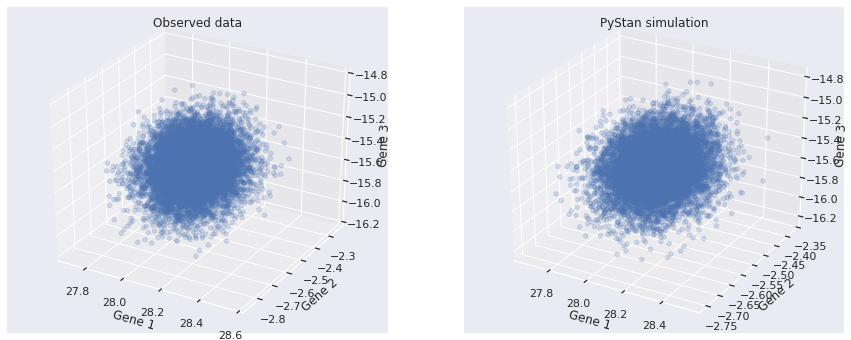

In [38]:
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x[0,:],x[1,:],x[2,:], alpha=0.2)
ax.set_title('Observed data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x_sim[0,:],x_sim[1,:],x_sim[2,:], alpha=0.2)
ax.set_title('PyStan simulation')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

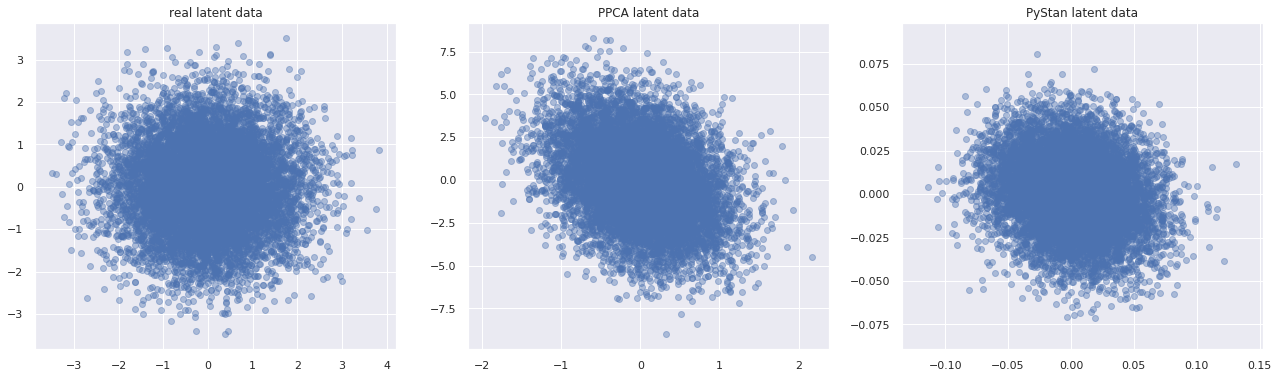

In [39]:
fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_ppca[0,:], z_ppca[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z_sim[0,:], z_sim[1,:], alpha=0.4)
ax.set_title('PyStan latent data')
plt.show()

## Generating Samples with PyStan

The following section tries to actually generate samples from our distribution. To be honest, PyStan does not lend itself for this feature. I have not found *any* examples of people generating data with PyStan. It is however possible to generate samples from the parameters that are optimized according to the distribution of their posterior probability. The following piece of code treats the output $x$ as a parameter which allows us to sample $x$. It is not a very elegant way to produce samples of the output variable. Besides that, PyStan will try to produce thousands of samples by default - meaning thousands of $\sigma^2$'s, accompanied by a thousand datapoints in $z$ and $x$ for *each* $\sigma^2$ (leading to millions of datapoints). It is possible to write a PyStan model that only outputs $1$ datapoint per run to reduce the number of datapoints, but this will draw a new value for $\sigma^2$ for each datapoint. It is also possible - as performed here in the cells below - to explicitly ask for only one sample of our data ($1$ $\sigma^2$ and $W$, but $1000$ datapoints in $z$ and $x$). Still, this will cause PyStan to generate a lot more samples so that the generating Markov chain has reached a stationary distribution, which is very inefficient computationally.

In [20]:
latent_sampling = """

data{
    int<lower=0> N;// number  of  datapoints
    int<lower=0> D;// number  of  dimensions  in  observed  dataset
    int<lower=0> M;// number  of  dimensions  in  latent  dataset
}


parameters{
    matrix[M,N] z;  // latent data
    matrix[N,D] x;//  observations
    matrix[D,M] W;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
}

model{
    //  priors
    to_vector(z) ~ normal(0.0,1.0);
    sigma~lognormal(0.0, 1.0) ;
    for (d in 1:D)
        W[d] ~ normal(0.0,sigma);
    
    //  likelihood
    for (n in 1:N)
        x[n] ~ normal(W*col(z,n), sigma);
}
"""
ppca_sampling = pystan.StanModel(model_code=latent_sampling)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_07f0256a61c07190db137f50319d640b NOW.


In [21]:
N=1000
M=2
D=3

samples = ppca_sampling.sampling(data={'N':N,'D':D,'M':M}, iter=100, warmup=99, chains=1)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)
/usr/lib/python3.7/site-packages/pystan/diagnostics.py:217: RuntimeWarning: invalid value encountered in true_divide
  e_bfmi = numer / denom


In [22]:
samples.extract()

OrderedDict([('z',
              array([[[-0.30736752, -0.36061101, -0.49768858, ...,  1.00318658,
                       -0.46191559,  0.4950442 ],
                      [-0.82623919, -0.53520915, -0.72253281, ...,  1.62185241,
                       -0.95643483, -0.38484171]]])),
             ('x', array([[[-0.3324997 ,  0.10999593,  0.38652104],
                      [ 1.90520643, -0.82490268,  0.8272359 ],
                      [ 0.49272984, -1.07831629,  0.43839743],
                      ...,
                      [-1.8115472 ,  1.40095496, -0.4995778 ],
                      [-0.86141537, -1.16440274, -0.34215789],
                      [ 0.79743576,  0.03446065,  1.31011766]]])),
             ('W', array([[[-0.57298497, -0.31265051],
                      [-0.51304225,  1.59459456],
                      [ 0.01050606, -0.48281958]]])),
             ('sigma', array([0.97494097])),
             ('lp__', array([-2493.71118788]))])